# PRICING AND HEDGING - Lista 2
## Exercício 5:
Usando dados reais (2 períodos de 6 meses, um calmo e outro de crise), calcule breakeven smiles de 3 e 6
meses.
## Using methods from exercise 3:

In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import scipy.optimize as opt

%matplotlib inline

def ca(x, size):
    y = np.empty(size)
    y.fill(x)
    return y

def ppzero(s):
    return pd.Series(pd.Series.append(pd.Series([0]), s).values)

def bsv(phi, S, K, r, q, vol, t):
    if (t > 0):
        fwd=S*np.exp((r-q)*t)
        efv=t*(vol**2)
        # calculate d1 and d2
        d1=(np.log(fwd/K)+(efv/2))/(np.sqrt(efv))
        d2=(np.log(fwd/K)-(efv/2))/(np.sqrt(efv))
        # calculate N(d1) and N(d2)
        Nd1=st.norm.cdf(phi*d1)
        Nd2=st.norm.cdf(phi*d2)
        # calculate premium
        pr=phi*S*np.exp(-q*t)*Nd1-phi*K*np.exp(-r*t)*Nd2
        # calculate delta
        de=phi*np.exp(-q*t)*Nd1
    else:
        de = 0
        if (phi == 1):
            pr = max(S-K, 0)
        else:
            pr = max(K-S, 0)
        
    return [pr, de]

def calcpath(path, phi, K ,r, q, vol, T):
    ttm=T-path.index
    bsvpath=np.array([[path.index[j], path.values[j]] + bsv(phi, path.values[j], K, r, q, vol, ttm[j])\
                      for j in range(len(path))])

    return pd.DataFrame(bsvpath,columns=['time','spot','premium','delta'])

def filldf(path, phi, K, r, q, vol, T):
    nstp=len(path)-1
    # calculate t,S(t),premium(t),delta(t)
    df=calcpath(path, phi, K, r, q, vol, T)
    # cashflows for the option
    df['cfwprem']=0
    df.loc[0,'cfwprem']=-df['premium'][0]
    df.loc[nstp,'cfwprem']=df['premium'][nstp]
    df.loc[nstp,'premium']=0
    # calculate time intervals dt
    df['timechg']=df['time'].diff()
    df.loc[0,'timechg']=0
    # calculate changes in delta
    df.loc[nstp,'delta']=0
    df['dltchg']=df['delta'].diff()
    df.loc[0,'dltchg']=0
    # calculate changes in spot price
    df['spotchg']=df['spot'].diff()
    df.loc[0,'spotchg']=0
    # cashflows for the asset
    df['cfwspot']=0
    df.loc[0,'cfwspot']=df['delta'][0]*df['spot'][0]
    df.loc[1:,'cfwspot']=df['dltchg'][1:]*df['spot'][1:]
    # dividend cashflows
    df['cfwdivid']=0
    df.loc[1:,'cfwdivid']=-((df['delta'][0:nstp]*df['spot'][0:nstp]).values)*(np.exp(q*df['timechg'][1:].values)-1)
    # cashflows before interest
    df['cfwprer']=df['cfwprem']+df['cfwspot']+df['cfwdivid']
    # interest and consolidation of cashflows
    df['balance']=0
    df.loc[0,'balance']=df['cfwprer'][0]
    for j in range(1,nstp+1):
        df.loc[j,'balance']=df['balance'][j-1]*(np.exp(r*df['timechg'][j]))+df['cfwprer'][j]
    # portfolio
    df['portf']=df['premium']-df['delta']*df['spot']+df['balance']
    # consolidated discount factor
    return df

def portfolio(path, phi, K, r, q, vol, T):
    fulldf=filldf(path, phi, K, r, q, vol, T)
    return pd.Series(fulldf['portf'].values)

def finalpl(vol, path, phi, K, r, q, T):
    portf=portfolio(path, phi, K, r, q, vol, T)
    return portf[len(path)-1]

def getStrikeByDelta(phi, delta, S, r, q, vol, t):
    return S * np.exp(phi* st.norm.ppf(delta * np.exp((r-q)*t)) * vol * np.sqrt(t) + ((vol**2)/2) * t)

def bevSmilesByPath(path, phi, strikes, r, q, vol, T):
    r = pd.Series(np.array([opt.newton(finalpl, vol, args=(path, phi, K, r, q, T)) for K in strikes]), index=strikes)
    return r

# Getting PETR4 quotes
font: finance.yahoo.com
column Adj Close (Close price adjusted for dividends and splits)
## Building calm path: from 01-Jun-2010 to 30-Nov-2010 (6 months)

In [2]:
# 124 business days annualized
nsteps_calm = 124
t_calm = nsteps_calm/252
dt_calm = t_calm/nsteps_calm

ts_calm = pd.Series(ca(dt_calm, nsteps_calm))
ts0_calm = ppzero(ts_calm)
cmts_calm = ts0_calm.cumsum()

S_calm = np.array([26.03094,26.4398,26.57609,26.82141,26.94861,26.84867,27.16667,26.91227,26.39437,26.34894
,26.93952,26.82141,26.79415,26.71238,26.44889,25.89465,24.97698,25.35859,24.91338,24.37732
,24.40457,24.03206,24.3228,24.11383,24.5772,24.89521,25.05875,24.74075,24.80435,24.80435
,24.63172,24.3864,24.48635,25.12236,24.98607,25.42219,25.24956,25.3495,25.42219,25.25864
,25.20413,25.30407,25.99884,26.5839,26.82159,26.90386,26.52905,26.35536,25.97141,25.13952
,25.16695,25.28579,25.24008,25.87085,25.50519,24.48133,24.48133,24.37162,23.89626,23.84141
,23.49403,24.28021,23.26549,23.82313,24.70987,25.23094,26.32794,26.59304,25.4412,25.05725
,25.15781,25.87085,24.54532,24.17965,24.09738,24.17051,24.77386,24.08823,23.74999,24.49961
,24.04253,24.22536,24.40819,25.13952,25.13952,25.13952,25.02982,24.66416,23.64029,23.12836
,23.76828,23.63115,23.50317,24.17051,24.03339,24.13394,23.11008,22.84497,22.08621,22.13192
,22.46102,23.63115,23.94197,24.00596,23.63115,24.21622,24.68244,25.13952,24.91098,25.16695
,24.79214,24.80128,24.42647,23.63115,23.21978,23.26549,23.67686,23.49403,22.90896,22.53415
,23.07351,22.71699,22.48845,22.57986,22.4793])

path_calm=pd.Series(S_calm, index=cmts_calm.values)

### Breakeven smile of 3 months for calm path:

In [3]:
call = 1
put = -1
impliedVol = 0.10
T = t_calm/2
q = 0
r = 0.099082194 # rate accumulated for the period (font: cetip.com.br)
phi = call

First we need to find the strikes related to each delta (-10 delta, -25 delta, ATM, 25 delta, 10 delta):

In [4]:
strikeDeltaMinus10 = getStrikeByDelta(put, 0.10, path_calm[0], r, q, impliedVol, T)
strikeMinus25 = getStrikeByDelta(put, 0.25, path_calm[0], r, q, impliedVol, T)
strikeATM = path_calm[0]
strikePlus25 = getStrikeByDelta(call, 0.25, path_calm[0], r, q, impliedVol, T)
strikePlus10 = getStrikeByDelta(call, 0.10, path_calm[0], r, q, impliedVol, T)

strikes = [strikeDeltaMinus10, strikeMinus25, strikeATM, strikePlus25, strikePlus10]
strikes

[27.754325933850062,
 26.923916755932627,
 26.030940000000001,
 25.229576784064179,
 24.474708077600397]

Find Break Even Smile for each strike:

In [5]:
calmPath3M = bevSmilesByPath(path_calm[:62], call, strikes, r, q, 0.30, T)
calmPath3M

27.754326    0.226244
26.923917    0.238308
26.030940    0.249104
25.229577    0.251220
24.474708    0.288935
dtype: float64

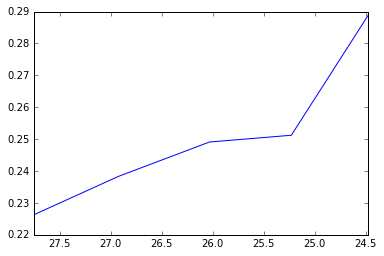

In [6]:
calmPath3M.plot()

### Breakeven smile of 6 months for calm path:

In [7]:
call = 1
put = -1
impliedVol = 0.10
T = t_calm
q = 0
r = 0.10376036 # rate accumulated for the period (font: cetip.com.br)
phi = call

Find the strikes related to each delta (-10 delta, -25 delta, ATM, 25 delta, 10 delta):

In [8]:
strikeDeltaMinus10 = getStrikeByDelta(put, 0.10, path_calm[0], r, q, impliedVol, T)
strikeMinus25 = getStrikeByDelta(put, 0.25, path_calm[0], r, q, impliedVol, T)
strikeATM = path_calm[0]
strikePlus25 = getStrikeByDelta(call, 0.25, path_calm[0], r, q, impliedVol, T)
strikePlus10 = getStrikeByDelta(call, 0.10, path_calm[0], r, q, impliedVol, T)

strikes = [strikeDeltaMinus10, strikeMinus25, strikeATM, strikePlus25, strikePlus10]
strikes

[28.491006148364853,
 27.281467490902205,
 26.030940000000001,
 24.960252778727973,
 23.900606430027732]

Find Break Even Smile for each strike:

In [9]:
calmPath6M = bevSmilesByPath(path_calm, call, strikes, r, q, 0.30, T)
calmPath6M

28.491006    0.304734
27.281467    0.309279
26.030940    0.313200
24.960253    0.316004
23.900606    0.316421
dtype: float64

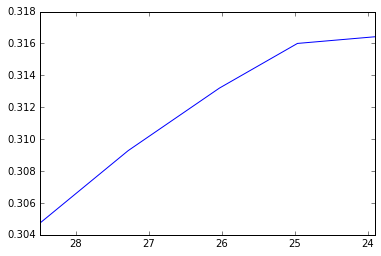

In [10]:
calmPath6M.plot()

## Building path during crisis: from 01-Dec-2015 to 31-May-2016 (6 months)

In [11]:
# 130 business days annualized
nsteps_crisis = 130
t_crisis = nsteps_crisis/252
dt_crisis = t_crisis/nsteps_crisis

ts_crisis = pd.Series(ca(dt_crisis, nsteps_crisis))
ts0_crisis = ppzero(ts_crisis)
cmts_crisis = ts0_crisis.cumsum()

S_crisis = np.array([7.49,7.52,7.98,7.52,7.19,7.13,7.65,7.45,7.25,7.21,7.42,7.29,7.2,7.02,6.64,6.79,6.93,6.93
,6.93,6.7,6.69,6.7,6.7,6.7,6.87,6.68,6.4,6.26,6.27,6.09,5.53,5.27,5.69,5.17,4.8,4.66
,4.43,4.5,4.41,4.41,4.2,4.57,4.6,4.84,4.72,4.3,4.49,4.73,4.54,4.54,4.54,4.31,4.23,4.45
,4.57,4.44,4.68,4.59,4.46,5.04,4.92,4.87,4.89,4.87,5.14,5.31,5.65,6.57,7.22,7.37,7.47
,7.6,7.95,8.09,7.4,6.61,7.23,8.1,8.12,8.06,8.11,7.78,7.81,7.81,8.44,8.49,8.44,8.35,8.36
,7.58,7.83,7.58,7.7,8.26,8.39,9.03,9.51,9.16,9.69,9.24,9.62,9.48,9.48,9.75,9.33,9.67
,10.25,10.23,10.23,10.17,9.78,9.92,9.81,10.08,9.48,10.21,10.25,9.79,9.46,9.75,9.5,9.32
,8.96,8.9,8.5,8.53,8.67,8.67,8.23,8.38,8.04])

path_crisis=pd.Series(S_crisis, index=cmts_crisis.values)

### Breakeven smile of 3 months for path during crisis:

In [12]:
call = 1
put = -1
impliedVol = 0.10
T = t_crisis/2
q = 0
r = 0.134276121 # rate accumulated for the period annualized (font: cetip.com.br)
phi = call

First we need to find the strikes related to each delta (-10 delta, -25 delta, ATM, 25 delta, 10 delta):

In [13]:
strikeDeltaMinus10 = getStrikeByDelta(put, 0.10, path_crisis[0], r, q, impliedVol, T)
strikeMinus25 = getStrikeByDelta(put, 0.25, path_crisis[0], r, q, impliedVol, T)
strikeATM = path_crisis[0]
strikePlus25 = getStrikeByDelta(call, 0.25, path_crisis[0], r, q, impliedVol, T)
strikePlus10 = getStrikeByDelta(call, 0.10, path_crisis[0], r, q, impliedVol, T)

strikes = [strikeDeltaMinus10, strikeMinus25, strikeATM, strikePlus25, strikePlus10]
strikes

[7.9959742758204451,
 7.7502014717950169,
 7.4900000000000002,
 7.2572293281153222,
 7.0341633776882295]

Find Break Even Smile for each strike:

In [14]:
crisisPath3M = bevSmilesByPath(path_crisis[:66], call, strikes, r, q, 0.30, T)
crisisPath3M

7.995974    0.644900
7.750201    1.008283
7.490000    1.296473
7.257229    1.511838
7.034163    1.696998
dtype: float64

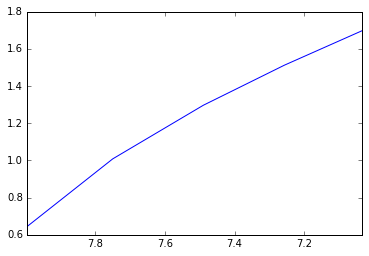

In [15]:
crisisPath3M.plot()

### Breakeven smile of 6 months for path during crisis:

In [16]:
call = 1
put = -1
impliedVol = 0.10
T = t_crisis
q = 0
r = 0.13763556 # rate accumulated for the period (font: cetip.com.br)
phi = call

Find the strikes related to each delta (-10 delta, -25 delta, ATM, 25 delta, 10 delta):

In [17]:
strikeDeltaMinus10 = getStrikeByDelta(put, 0.10, path_crisis[0], r, q, impliedVol, T)
strikeMinus25 = getStrikeByDelta(put, 0.25, path_crisis[0], r, q, impliedVol, T)
strikeATM = path_crisis[0]
strikePlus25 = getStrikeByDelta(call, 0.25, path_crisis[0], r, q, impliedVol, T)
strikePlus10 = getStrikeByDelta(call, 0.10, path_crisis[0], r, q, impliedVol, T)

strikes = [strikeDeltaMinus10, strikeMinus25, strikeATM, strikePlus25, strikePlus10]
strikes

[8.2092415430002728,
 7.8499878345339216,
 7.4900000000000002,
 7.1834828580066405,
 6.8691185110781694]

Find Break Even Smile for each strike:

In [18]:
crisisPath6M = bevSmilesByPath(path_crisis, call, strikes, r, q, 0.30, T)
crisisPath6M

8.209242    0.672683
7.849988    0.690923
7.490000    0.730691
7.183483    0.753598
6.869119    0.771447
dtype: float64

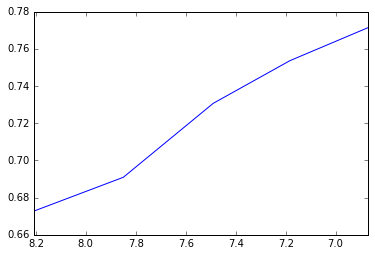

In [19]:
crisisPath6M.plot()